# Calculate the Network Upgrade Cost

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy import interpolate
import seaborn as sns
import copy
from copy import deepcopy
import geopandas as gpd

In [90]:
network_root_path = os.path.join(os.path.dirname(os.getcwd()), 'FuelPoverty_data', 'UKM_PrimarySubstation_Data')
UKM_PS_df = pd.read_csv(os.path.join(network_root_path, "UKM_PS_data.csv"))
### exclude Wales data
UKM_PS_df = UKM_PS_df[~UKM_PS_df["RegCode"].str.contains("W")]

UKM_PS_df

,PS Name,Firm Capacity (MVA),Demand (MVA),PF,RegName,RegCode,"Geo(Long,Lat)",DNO,Zone0,Zone1
0,albion st,22.86300,14.312793,0.998712,north west,E12000002,"-2.4950937454916797,53.73015403195597",ENW,E02002623,E02002627
1,alderley & chelford,28.42300,16.181206,0.975600,north west,E12000002,"-2.225911796847622,53.30796142675533",ENW,E02003864,E02003858
2,alston,1.71206,1.694467,0.985752,north west,E12000002,"-2.4352546655219385,54.81256830516162",ENW,E02005728,E02004008
3,ambleside,17.84830,9.760703,0.993175,north west,E12000002,"-2.963194161426022,54.42314157846089",ENW,E02004015,E02004016
4,ancoats north t11 & t12,22.86900,16.170613,0.992857,north west,E12000002,"-2.2271891138444646,53.485968874301655",ENW,E02006902,E02006912
...,...,...,...,...,...,...,...,...,...,...
4202,worthington,9.50000,7.220000,0.985506,east midlands,E12000004,"-1.3794,52.7825",WPD,E02005400,E02005401
4203,wragby,8.00000,5.620000,0.985506,east midlands,E12000004,"-0.3075,53.2866",WPD,E02005430,E02005494
4204,wrangle,12.00000,11.620000,0.985506,east midlands,E12000004,"0.1201,53.0411",WPD,E02005417,E02005436
4205,wribbenhall,23.00000,14.720000,0.985506,west midlands,E12000005,"-2.3076,52.3853",WPD,E02006771,E02006777


In [91]:
pd.read_csv(os.path.join(network_root_path, "UKM_PS_data.csv"))['Firm Capacity (MVA)'].median()

18.343723400552935

In [92]:
# heating proportion
census_root_path = os.path.join(os.path.dirname(os.getcwd()), "FuelPoverty_data", "Census")
eng_heat_prop_df = pd.read_csv(os.path.join(census_root_path, "2021CensusFuelProportionEnglandWales_MSOA.csv"))[["Middle Layer Super Output Areas Code", "Type of central heating in household (13 categories)", "Observation"]]

# pivot it
eng_heat_prop_df = eng_heat_prop_df.pivot_table(values='Observation', index="Middle Layer Super Output Areas Code", columns='Type of central heating in household (13 categories)').reset_index()

# extract england data, i.e., remove Wales data
eng_heat_prop_dfonlyE = eng_heat_prop_df[eng_heat_prop_df["Middle Layer Super Output Areas Code"].str.contains("E")].copy()

# scotland data needs to be processed
scot_heat_prop_df = pd.read_csv(os.path.join(census_root_path, "Scotland", "QS415SC.csv"), header = 3).iloc[:-3,:]
for i in range(8):
    scot_heat_prop_df[scot_heat_prop_df.columns[i+1]] = pd.to_numeric(scot_heat_prop_df.iloc[:,i+1], errors='coerce').replace(np.nan, 0)

scot_zonelookup_df = pd.read_csv(os.path.join(census_root_path, "Scotland", "DataZone2011lookup.csv"))
# process scot_heat_prop_df so that it becomes data per intermediate zone
scot_zonelookup_dict = {scot_zonelookup_df.iloc[i]["DZ2011_Code"]: scot_zonelookup_df.iloc[i]["IZ2011_Code"] for i in range(len(scot_zonelookup_df))}
scot_zonelookup_dict["Scotland"] = "Scotland"
scot_heat_prop_df["IZ_code"] = scot_heat_prop_df.iloc[:,0].map(scot_zonelookup_dict)
scot_heat_prop_df.drop(columns = ["Unnamed: 0"], inplace = True)
scot_heat_prop_df = scot_heat_prop_df.groupby(by="IZ_code").sum().reset_index()
scot_heat_prop_df

,IZ_code,All occupied household spaces,No central heating,Gas central heating,Electric (including storage heaters) central heating,Oil central heating,"Solid fuel (for example wood, coal) central heating",Other central heating,Two or more types of central heating
0,S02001236,2143.0,27.0,1683.0,264.0,108.0,10.0,7.0,44.0
1,S02001237,1428.0,12.0,1218.0,48.0,117.0,1.0,10.0,22.0
2,S02001238,2291.0,13.0,2033.0,157.0,57.0,1.0,2.0,28.0
3,S02001239,2439.0,39.0,1995.0,334.0,8.0,2.0,7.0,54.0
4,S02001240,2193.0,64.0,1894.0,192.0,3.0,0.0,4.0,36.0
...,...,...,...,...,...,...,...,...,...
1275,S02002511,1780.0,23.0,1574.0,125.0,10.0,10.0,2.0,36.0
1276,S02002512,2485.0,28.0,2192.0,154.0,48.0,9.0,7.0,47.0
1277,S02002513,1479.0,15.0,1372.0,61.0,4.0,3.0,5.0,19.0
1278,S02002514,1277.0,9.0,1113.0,91.0,24.0,6.0,8.0,26.0


In [93]:
eng_heat_prop_df

Type of central heating in household (13 categories),Middle Layer Super Output Areas Code,District or communal heat networks only,Does not apply,Electric only,Mains gas only,No central heating,Oil only,Other central heating only,Renewable energy only,Solid fuel only,Tank or bottled gas only,Two or more types of central heating (including renewable energy),Two or more types of central heating (not including renewable energy),Wood only
0,E02000001,915,0,1937,1323,184,15,145,9,0,29,9,348,1
1,E02000002,42,0,317,2116,63,1,49,3,0,15,13,252,0
2,E02000003,20,0,416,2981,89,4,78,6,0,14,11,310,1
3,E02000004,6,0,82,1958,23,2,31,0,0,21,4,181,0
4,E02000005,23,0,221,2887,69,0,65,1,0,19,26,316,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7259,W02000424,2,0,67,2397,8,145,8,9,7,56,19,249,3
7260,W02000425,5,0,143,1600,18,577,4,19,16,183,20,272,15
7261,W02000426,2,0,85,3871,32,30,10,4,3,18,12,326,2
7262,W02000427,3,0,110,4015,41,136,22,7,94,53,14,381,14


## We further process these two dataframes, making them contain:
1. Number of HP replacement (nongas heating)
2. Number of Electric heating to be replaced
3. Number of households in total

### Scotland

In [94]:
res = scot_heat_prop_df[scot_heat_prop_df["IZ_code"] == "Scotland"][["No central heating", "Other central heating"]].values.sum() / scot_heat_prop_df[scot_heat_prop_df["IZ_code"] == "Scotland"][["All occupied household spaces"]].values.sum()

print(f"No central heating and Other central heating only occupy 3% of the Scotland's data and are therefore dropped")

scot_heat_prop_df.drop(columns = ["No central heating", "Other central heating"], inplace = True)

No central heating and Other central heating only occupy 3% of the Scotland's data and are therefore dropped


In [95]:
res = scot_heat_prop_df[scot_heat_prop_df["IZ_code"] == "Scotland"][["Gas central heating"]].values.sum() / scot_heat_prop_df[scot_heat_prop_df["IZ_code"] == "Scotland"][scot_heat_prop_df.columns[2:]].values.sum()
print(f"from the census data, the gas rate is {res}")
print("However, the SHCS data shows the gas rate is 0.801")

res = scot_heat_prop_df[scot_heat_prop_df["IZ_code"] == "Scotland"][["Gas central heating", "Two or more types of central heating"]].values.sum() / scot_heat_prop_df[scot_heat_prop_df["IZ_code"] == "Scotland"][scot_heat_prop_df.columns[2:]].values.sum()
print(f"from the census data, the gas+two or more types rate is {res}, which is closer to SHCS")
print("So we can conclude that SHCS consider two or more types as gas, so we consider two or more types as the one no need for replacement")
print()
res = scot_heat_prop_df[scot_heat_prop_df["IZ_code"] == "Scotland"][["Electric (including storage heaters) central heating"]].values.sum() / scot_heat_prop_df[scot_heat_prop_df["IZ_code"] == "Scotland"][scot_heat_prop_df.columns[2:]].values.sum()
print(f"from the census data, the electric heating rate is {res}, which is closed to SHCS 0.107")

from the census data, the gas rate is 0.7654388746065103
However, the SHCS data shows the gas rate is 0.801
from the census data, the gas+two or more types rate is 0.7917338054340249, which is closer to SHCS
So we can conclude that SHCS consider two or more types as gas, so we consider two or more types as the one no need for replacement

from the census data, the electric heating rate is 0.13811509105668163, which is closed to SHCS 0.107


In [96]:
processed_scot_heat_prop_df = scot_heat_prop_df.copy()
processed_scot_heat_prop_df["HP replace no"] = scot_heat_prop_df[["Electric (including storage heaters) central heating", "Oil central heating", "Solid fuel (for example wood, coal) central heating"]].values.sum(1)

processed_scot_heat_prop_df["Electricity no"] = scot_heat_prop_df[["Electric (including storage heaters) central heating"]].values.sum(1)

processed_scot_heat_prop_df["Tot no"] =  scot_heat_prop_df[scot_heat_prop_df.columns[2:]].values.sum(1)

processed_scot_heat_prop_df.drop(columns = scot_heat_prop_df.columns[1:], inplace=True)
processed_scot_heat_prop_df.rename(columns = {"IZ_code":"Zone"}, inplace = True)
processed_scot_heat_prop_df

,Zone,HP replace no,Electricity no,Tot no
0,S02001236,382.0,264.0,2109.0
1,S02001237,166.0,48.0,1406.0
2,S02001238,215.0,157.0,2276.0
3,S02001239,344.0,334.0,2393.0
4,S02001240,195.0,192.0,2125.0
...,...,...,...,...
1275,S02002511,145.0,125.0,1755.0
1276,S02002512,211.0,154.0,2450.0
1277,S02002513,68.0,61.0,1459.0
1278,S02002514,121.0,91.0,1260.0


### England

In [97]:
heatingoption_drop_subset = ["Does not apply", "No central heating", "Renewable energy only", "Other central heating only", "Two or more types of central heating (including renewable energy)"]
percen = eng_heat_prop_df[heatingoption_drop_subset].values.sum() / eng_heat_prop_df[eng_heat_prop_df.columns[1:]].values.sum()
print(f"The rest of the 5 options account for the {percen*100}% households in England and Wales")
print("so we can safely remove them")

eng_heat_prop_dfonlyE.drop(columns = heatingoption_drop_subset, inplace = True)
eng_heat_prop_df.drop(columns = heatingoption_drop_subset, inplace = True)

The rest of the 5 options account for the 3.332939379837573% households in England and Wales
so we can safely remove them


In [98]:
res = eng_heat_prop_dfonlyE[["Mains gas only"]].values.sum() / eng_heat_prop_dfonlyE[eng_heat_prop_dfonlyE.columns[1:]].values.sum()
print(f"from the census data, the gas rate is {res}")
print("However, the EHS data shows the gas rate is 87.12%")

res = eng_heat_prop_dfonlyE[["Mains gas only", "District or communal heat networks only", "Two or more types of central heating (not including renewable energy)"]].values.sum() / eng_heat_prop_dfonlyE[eng_heat_prop_dfonlyE.columns[1:]].values.sum()
print(f"from the census data, the gas+district heating+two or more types rate is {res*100}%, which is closer to EHS data")
print("So we can conclude that EHS's gas includes 'gas', 'communal heating', 'two or more types', so we consider these three as no need for replacement")

from the census data, the gas rate is 0.7653824979825581
However, the EHS data shows the gas rate is 87.12%
from the census data, the gas+district heating+two or more types rate is 86.27763286106912%, which is closer to EHS data
So we can conclude that EHS's gas includes 'gas', 'communal heating', 'two or more types', so we consider these three as no need for replacement


In [99]:
eng_offgas_no_df = eng_heat_prop_df.sum(axis=0)[["Electric only", "Oil only", "Solid fuel only", "Tank or bottled gas only", "Wood only"]]
eng_offgas_no_df[["Electric only", "Oil only", "Solid fuel only"]].sum() / eng_offgas_no_df.sum()

0.9110285897878659

In [100]:
processed_eng_heat_prop_df = eng_heat_prop_df.copy()
processed_eng_heat_prop_df["HP replace no"] = eng_heat_prop_df[["Electric only", "Oil only", "Solid fuel only", "Tank or bottled gas only", "Wood only"]].values.sum(1)

processed_eng_heat_prop_df["Electricity no"] = eng_heat_prop_df[["Electric only"]].values.sum(1)

processed_eng_heat_prop_df["Tot no"] = eng_heat_prop_df[eng_heat_prop_df.columns[1:]].values.sum(1)

processed_eng_heat_prop_df.drop(columns = eng_heat_prop_df.columns[1:], inplace=True)
processed_eng_heat_prop_df.rename(columns={"Middle Layer Super Output Areas Code":"Zone"}, inplace = True)
processed_eng_heat_prop_df

Type of central heating in household (13 categories),Zone,HP replace no,Electricity no,Tot no
0,E02000001,1982,1937,4568
1,E02000002,333,317,2743
2,E02000003,435,416,3746
3,E02000004,105,82,2250
4,E02000005,240,221,3466
...,...,...,...,...
7259,W02000424,278,67,2926
7260,W02000425,934,143,2811
7261,W02000426,138,85,4337
7262,W02000427,407,110,4806


In [101]:
processed_eng_heat_prop_df[processed_eng_heat_prop_df["Zone"].str.contains("E")]["Tot no"].sum()

22647492

In [102]:
processed_heat_prop_df = pd.concat([processed_scot_heat_prop_df, processed_eng_heat_prop_df], axis=0)
# this is what we will use later
processed_heat_prop_df

,Zone,HP replace no,Electricity no,Tot no
0,S02001236,382.0,264.0,2109.0
1,S02001237,166.0,48.0,1406.0
2,S02001238,215.0,157.0,2276.0
3,S02001239,344.0,334.0,2393.0
4,S02001240,195.0,192.0,2125.0
...,...,...,...,...
7259,W02000424,278.0,67.0,2926.0
7260,W02000425,934.0,143.0,2811.0
7261,W02000426,138.0,85.0,4337.0
7262,W02000427,407.0,110.0,4806.0


## No. of household for each PS
We first need to have the total number of households for each region

### Scotland
This needs to be mannally aggregated as they did not provide the higher level data

In [103]:
scot_houseno_df = scot_heat_prop_df.iloc[:,:2].copy()
# process scot_heat_prop_df so that it becomes data per intermediate zone
scot_zonelookup_dict = {scot_zonelookup_df.iloc[i]["IZ2011_Code"]: scot_zonelookup_df.iloc[i]["LA_Code"] for i in range(len(scot_zonelookup_df))}
scot_zonelookup_dict["Scotland"] = "Scotland"
scot_houseno_df["LA_code"] = scot_houseno_df.iloc[:,0].map(scot_zonelookup_dict)
scot_houseno_df = scot_houseno_df.groupby(by="LA_code").sum(numeric_only = True).reset_index()
scot_la2householdno_dict = {scot_houseno_df.iloc[i]["LA_code"]: scot_houseno_df.iloc[i]["All occupied household spaces"] for i in range(len(scot_houseno_df))}

scot_la2householdno_dict

# '''
# I want to save scot_la2householdno_dict by json
# '''
# np.save(os.path.join(census_root_path, "scot_la2householdno_dict.npy"), scot_la2householdno_dict, allow_pickle=True)

{'S12000005': 22734.0,
 'S12000006': 67980.0,
 'S12000008': 53919.0,
 'S12000010': 42905.0,
 'S12000011': 37225.0,
 'S12000013': 12576.0,
 'S12000014': 68732.0,
 'S12000017': 102091.0,
 'S12000018': 37434.0,
 'S12000019': 34978.0,
 'S12000020': 40062.0,
 'S12000021': 62498.0,
 'S12000023': 9725.0,
 'S12000026': 52498.0,
 'S12000027': 9950.0,
 'S12000028': 51286.0,
 'S12000029': 139188.0,
 'S12000030': 37566.0,
 'S12000033': 103371.0,
 'S12000034': 104714.0,
 'S12000035': 40125.0,
 'S12000036': 223051.0,
 'S12000038': 80902.0,
 'S12000039': 42167.0,
 'S12000040': 73398.0,
 'S12000041': 51616.0,
 'S12000042': 69193.0,
 'S12000045': 43473.0,
 'S12000047': 160952.0,
 'S12000048': 64777.0,
 'S12000049': 285693.0,
 'S12000050': 145998.0,
 'Scotland': 2372777.0}

In [104]:
census_root_path

'C:\\Users\\Zhou_Ming\\Desktop\\Coding\\FuelPoverty\\FuelPoverty_data\\Census'

### England
In which we can directly load the data

In [105]:
eng_houseno_df = pd.read_csv(os.path.join(census_root_path, "2021Census_Region_householdno.csv"))
eng_houseno_df = eng_houseno_df[eng_houseno_df["Regions Code"].str.contains("E")]
eng_reg2householdno_dict = {eng_houseno_df.iloc[i]["Regions Code"]: eng_houseno_df.iloc[i]["Observation"] for i in range(len(eng_houseno_df))}

eng_reg2householdno_dict

{'E12000001': 1175680,
 'E12000002': 3153404,
 'E12000003': 2330658,
 'E12000004': 2037332,
 'E12000005': 2429493,
 'E12000006': 2628782,
 'E12000007': 3423890,
 'E12000008': 3807966,
 'E12000009': 2448881}

In [106]:
la2householdno_dict = {**scot_la2householdno_dict, **eng_reg2householdno_dict}
##
PS_household_no_list = []
for i in range(len(UKM_PS_df)):
    reg_code = UKM_PS_df.iloc[i]['RegCode']
    demand = UKM_PS_df.iloc[i]['Demand (MVA)']
    reg_total_demand = UKM_PS_df[UKM_PS_df["RegCode"] == reg_code]["Demand (MVA)"].sum()
    prop_by_demand = demand / reg_total_demand
    household_no = prop_by_demand * la2householdno_dict[reg_code]

    PS_household_no_list.append(household_no)

UKM_PS_df["Household no"] = PS_household_no_list

In [107]:
round(UKM_PS_df["Household no"].sum()) == round(scot_la2householdno_dict["Scotland"] + sum(eng_reg2householdno_dict.values()))

True

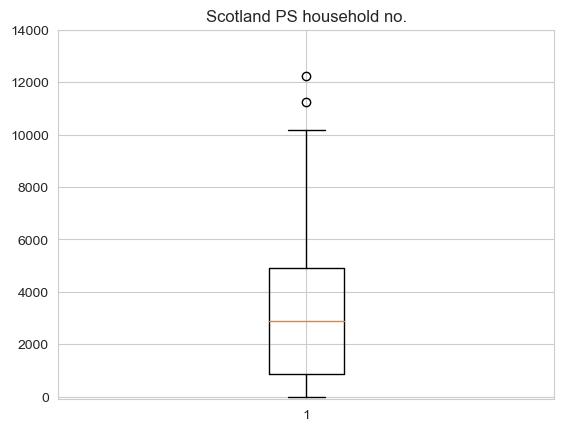

Total number of Scotland PS is 746
mean is 3180.6662198391423, median is 2872.972942389073


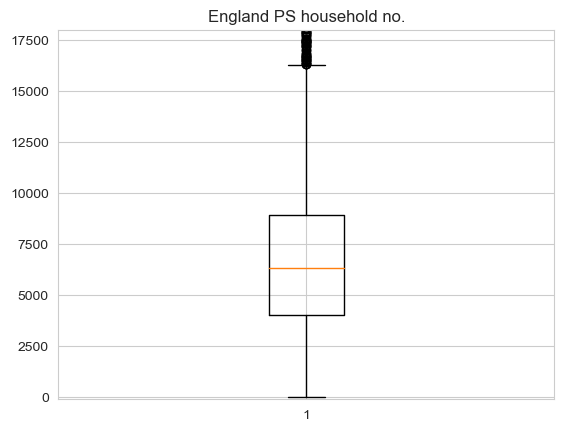

Total number of England PS is 3145
mean is 7451.855643879173, median is 6320.913616207598


In [108]:
plt.boxplot(UKM_PS_df[UKM_PS_df["RegCode"].str.contains("S")]["Household no"])
plt.title("Scotland PS household no.")
plt.ylim([-100,14000])
mean = UKM_PS_df[UKM_PS_df["RegCode"].str.contains("S")]["Household no"].mean()
median = UKM_PS_df[UKM_PS_df["RegCode"].str.contains("S")]["Household no"].median()
plt.show()
print(f"Total number of Scotland PS is {len(UKM_PS_df[UKM_PS_df['RegCode'].str.contains('S')])}")
print(f"mean is {mean}, median is {median}")

plt.boxplot(UKM_PS_df[UKM_PS_df["RegCode"].str.contains("E")]["Household no"])
plt.title("England PS household no.")
plt.ylim([-100,18000])
mean = UKM_PS_df[UKM_PS_df["RegCode"].str.contains("E")]["Household no"].mean()
median = UKM_PS_df[UKM_PS_df["RegCode"].str.contains("E")]["Household no"].median()
plt.show()
print(f"Total number of England PS is {len(UKM_PS_df[UKM_PS_df['RegCode'].str.contains('E')])}")
print(f"mean is {mean}, median is {median}")

The summed households for each PS is equal to the total number in Scotland and England, so the df is correct

## Number of Household & Demand in elec and nongas for each PS

In [109]:
zone2HPno = {processed_heat_prop_df.iloc[i]["Zone"]: processed_heat_prop_df.iloc[i]["HP replace no"] for i in range(len(processed_heat_prop_df))}
zone2Eno = {processed_heat_prop_df.iloc[i]["Zone"]: processed_heat_prop_df.iloc[i]["Electricity no"] for i in range(len(processed_heat_prop_df))}
zone2Totno = {processed_heat_prop_df.iloc[i]["Zone"]: processed_heat_prop_df.iloc[i]["Tot no"] for i in range(len(processed_heat_prop_df))}

HP_no = 0
E_no = 0
Tot_no = 0
k = 2
for i in range(k):
    HP_no = HP_no + UKM_PS_df[f"Zone{i}"].map(zone2HPno).values
    E_no = E_no + UKM_PS_df[f"Zone{i}"].map(zone2Eno).values
    Tot_no = Tot_no + UKM_PS_df[f"Zone{i}"].map(zone2Totno).values

HP_prop = HP_no / Tot_no
E_prop = E_no / Tot_no

UKM_PS_df["HP no"] = HP_prop * UKM_PS_df["Household no"].values
UKM_PS_df["Elec no"] = E_prop * UKM_PS_df["Household no"].values

#  The Mean demand for each PS is it's regions's mean demand
FP_root_path = os.path.join(os.path.dirname(os.getcwd()), 'FuelPoverty_data')
import pickle

with open(os.path.join(FP_root_path, "HeatingProfileandDemand", 'reg_aveheatenergy.pkl'), 'rb') as f:
    reg_aveheatenergy = pickle.load(f)

UKM_PS_df["Household Meanheatingenergy (MWh)"] = UKM_PS_df["RegName"].map(reg_aveheatenergy) / 1000 # the unit needs to match demand in MW
UKM_PS_df

,PS Name,Firm Capacity (MVA),Demand (MVA),PF,RegName,RegCode,"Geo(Long,Lat)",DNO,Zone0,Zone1,Household no,HP no,Elec no,Household Meanheatingenergy (MWh)
0,albion st,22.86300,14.312793,0.998712,north west,E12000002,"-2.4950937454916797,53.73015403195597",ENW,E02002623,E02002627,7849.991260,405.775598,352.243198,15.887027
1,alderley & chelford,28.42300,16.181206,0.975600,north west,E12000002,"-2.225911796847622,53.30796142675533",ENW,E02003864,E02003858,8874.740516,1385.786972,974.847337,15.887027
2,alston,1.71206,1.694467,0.985752,north west,E12000002,"-2.4352546655219385,54.81256830516162",ENW,E02005728,E02004008,929.346906,442.828772,54.075889,15.887027
3,ambleside,17.84830,9.760703,0.993175,north west,E12000002,"-2.963194161426022,54.42314157846089",ENW,E02004015,E02004016,5353.352849,1050.313614,601.056663,15.887027
4,ancoats north t11 & t12,22.86900,16.170613,0.992857,north west,E12000002,"-2.2271891138444646,53.485968874301655",ENW,E02006902,E02006912,8868.930773,6954.612572,6907.971345,15.887027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4202,worthington,9.50000,7.220000,0.985506,east midlands,E12000004,"-1.3794,52.7825",WPD,E02005400,E02005401,3544.732870,857.145236,200.117173,15.754403
4203,wragby,8.00000,5.620000,0.985506,east midlands,E12000004,"-0.3075,53.2866",WPD,E02005430,E02005494,2759.196500,1171.744559,242.338936,15.754403
4204,wrangle,12.00000,11.620000,0.985506,east midlands,E12000004,"0.1201,53.0411",WPD,E02005417,E02005436,5704.957887,2557.394915,482.146225,15.754403
4205,wribbenhall,23.00000,14.720000,0.985506,west midlands,E12000005,"-2.3076,52.3853",WPD,E02006771,E02006777,10512.377958,2967.665531,589.825631,16.555083


In [110]:
(UKM_PS_df["Household no"] >= UKM_PS_df["HP no"]).all()

True

### These two need to be further scaled so their summation match the total number in the region

Note that our fuel poverty dataset also has information on the number of households in each heating option, but for the region (LA for Scotland and Government Regions for England) in total. For better consistency, we need to scale the estimated number of various heaters for each PS so that the summed number of heaters of all the PSs for this region matches the fuel poverty dataset.

In [111]:
with open(os.path.join(FP_root_path, "HeatingProfileandDemand", 'reg_nongas_rate.pkl'), 'rb') as f:
    reg_nongas_rate = pickle.load(f)
with open(os.path.join(FP_root_path, "HeatingProfileandDemand", 'reg_elec_rate.pkl'), 'rb') as f:
    reg_elec_rate = pickle.load(f)

In [112]:
for regname in reg_nongas_rate.keys():
    index = UKM_PS_df["RegName"] == regname
    if not index.sum():
        print(regname)
        continue
    regcode = UKM_PS_df.loc[index, "RegCode"].iloc[0]
    reg_tot_household_no = la2householdno_dict[regcode]
    regHPno = reg_tot_household_no * reg_nongas_rate[regname]
    regEno = reg_tot_household_no * reg_elec_rate[regname]

    HPscaling_fac = regHPno / UKM_PS_df.loc[index, "HP no"].sum()
    Escaling_fac = regEno / UKM_PS_df.loc[index, "Elec no"].sum()

    print(HPscaling_fac, Escaling_fac)

    UKM_PS_df.loc[index, "HP no"] = HPscaling_fac * UKM_PS_df.loc[index, "HP no"]
    UKM_PS_df.loc[index, "Elec no"] = Escaling_fac * UKM_PS_df.loc[index, "Elec no"]

UKM_PS_df

1.0663367034296016 0.6034359407817743
0.946345896251611 0.6989793024245027
0.9251010812903361 0.8334976946308404
0.958309694998327 0.7835721526849312
0.6480428319589843 0.534163710198643
1.3820283436451268 0.8796577487459244
1.2912013996684837 0.7737614806995737
1.2145160118851304 1.0699190227609845
0.8019536155039427 0.4496786549691775
0.5702171707986411 0.46744758956728094
1.117345932377712 0.5407081494019307
1.081304395273388 0.9717582348912973
1.0888092385937325 1.11261377054005
0.8337391922341094 0.5889935325991662
0.6970443395973107 0.5911343481894381
1.154028227976779 0.7909709211001987
1.0841139427347044 0.749243736825379
0.9273430847643621 0.5924491507551972
1.3560576714575727 1.2601520672310422
1.3459452901365827 0.8182577023223458
0.9079049776112602 0.777866153880915
0.9612670411706924 0.6127426110895412
0.691527353548751 0.5239343803429968
0.6427113790111555 0.5651922821947786
0.4311173037182753 0.4174250197977769
0.9779534989368597 0.8074518708033517
0.8887088483281579 0.6

,PS Name,Firm Capacity (MVA),Demand (MVA),PF,RegName,RegCode,"Geo(Long,Lat)",DNO,Zone0,Zone1,Household no,HP no,Elec no,Household Meanheatingenergy (MWh)
0,albion st,22.86300,14.312793,0.998712,north west,E12000002,"-2.4950937454916797,53.73015403195597",ENW,E02002623,E02002627,7849.991260,254.871800,184.747538,15.887027
1,alderley & chelford,28.42300,16.181206,0.975600,north west,E12000002,"-2.225911796847622,53.30796142675533",ENW,E02003864,E02003858,8874.740516,870.426959,511.296306,15.887027
2,alston,1.71206,1.694467,0.985752,north west,E12000002,"-2.4352546655219385,54.81256830516162",ENW,E02005728,E02004008,929.346906,278.145277,28.362187,15.887027
3,ambleside,17.84830,9.760703,0.993175,north west,E12000002,"-2.963194161426022,54.42314157846089",ENW,E02004015,E02004016,5353.352849,659.712715,315.247362,15.887027
4,ancoats north t11 & t12,22.86900,16.170613,0.992857,north west,E12000002,"-2.2271891138444646,53.485968874301655",ENW,E02006902,E02006912,8868.930773,4368.263228,3623.152156,15.887027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4202,worthington,9.50000,7.220000,0.985506,east midlands,E12000004,"-1.3794,52.7825",WPD,E02005400,E02005401,3544.732870,867.814066,165.936593,15.754403
4203,wragby,8.00000,5.620000,0.985506,east midlands,E12000004,"-0.3075,53.2866",WPD,E02005430,E02005494,2759.196500,1186.329187,200.946759,15.754403
4204,wrangle,12.00000,11.620000,0.985506,east midlands,E12000004,"0.1201,53.0411",WPD,E02005417,E02005436,5704.957887,2589.226642,399.794283,15.754403
4205,wribbenhall,23.00000,14.720000,0.985506,west midlands,E12000005,"-2.3076,52.3853",WPD,E02006771,E02006777,10512.377958,1954.997231,349.429532,16.555083


## Load Demand Cruve

In [113]:
root_path = os.path.join(os.path.dirname(os.getcwd()), "FuelPoverty_data", "HeatingProfileandDemand")
heat_profile_df = pd.read_csv(os.path.join(root_path, "heat_tech_profiles.csv"))
heat_profile_df

,index,Normalised_ASHP_heat,Normalised_ASHP_elec,Normalised_GSHP_heat,Normalised_GSHP_elec,Normalised_Resistance_heater_heat,Normalised_Resistance_heater_elec,Normalised_Gas_boiler_heat,Normalised_Gas_boiler_gas,UK_daily_average_OAT_[degrees_C]
0,2013-01-01T00:00:00,0.000053,0.000023,0.000065,0.000026,0.000042,0.000042,0.000015,0.000018,7.3
1,2013-01-01T00:30:00,0.000053,0.000023,0.000066,0.000026,0.000089,0.000089,0.000015,0.000018,7.3
2,2013-01-01T01:00:00,0.000054,0.000024,0.000069,0.000026,0.000091,0.000091,0.000015,0.000018,7.3
3,2013-01-01T01:30:00,0.000054,0.000024,0.000068,0.000026,0.000090,0.000090,0.000015,0.000018,7.3
4,2013-01-01T02:00:00,0.000058,0.000026,0.000071,0.000026,0.000087,0.000087,0.000015,0.000018,7.3
...,...,...,...,...,...,...,...,...,...,...
17515,2013-12-31T21:30:00,0.000096,0.000037,0.000091,0.000034,0.000067,0.000067,0.000059,0.000070,7.5
17516,2013-12-31T22:00:00,0.000081,0.000033,0.000088,0.000033,0.000063,0.000063,0.000053,0.000063,7.5
17517,2013-12-31T22:30:00,0.000065,0.000028,0.000083,0.000031,0.000056,0.000056,0.000049,0.000058,7.5
17518,2013-12-31T23:00:00,0.000056,0.000026,0.000078,0.000030,0.000054,0.000054,0.000043,0.000051,7.5


In [114]:
normalised_HP_elec = heat_profile_df["Normalised_ASHP_elec"].values / (heat_profile_df["Normalised_ASHP_elec"].sum() * 0.5) # 0.5 because the resolution is half hour.
normalised_Resist_elec = heat_profile_df["Normalised_Resistance_heater_elec"].values / (heat_profile_df["Normalised_Resistance_heater_elec"].sum()*0.5)

### Heating Pattern

In [115]:
import datetime
year = 2019
# Create a list of i-th day indices for all the weekdays in the year
weekday_indices = [day - 1 for day in range(1, 366) if (datetime.date(year, 1, 1) + datetime.timedelta(day - 1)).weekday() < 5]
weekend_indices = [day - 1 for day in range(1, 366) if (datetime.date(year, 1, 1) + datetime.timedelta(day - 1)).weekday() >= 5]
#
normalised_HP_elec = normalised_HP_elec.reshape([-1, 48])
normalised_Resist_elec = normalised_Resist_elec.reshape([-1, 48])
#
# ### modify the demand in weekday
normalised_HP_elec[weekday_indices, 0:12] = 0
normalised_HP_elec[weekday_indices, 16:34] = 0

normalised_Resist_elec[weekday_indices, 0:12] = 0
normalised_Resist_elec[weekday_indices, 16:34] = 0

### modify the demand in weekends
normalised_HP_elec[weekend_indices, 0:16] = 0
normalised_Resist_elec[weekend_indices, 0:16] = 0

### only keep demand from October to May
off_season_indices = [day - 1 for day in range(1, 366) if ((datetime.date(year, 1, 1) + datetime.timedelta(day - 1)).month > 5) & ((datetime.date(year, 1, 1) + datetime.timedelta(day - 1)).month < 10)]
normalised_HP_elec[off_season_indices] = 0
normalised_Resist_elec[off_season_indices] = 0

# normalise and reshape back
normalised_HP_elec = normalised_HP_elec.flatten() / (0.5*normalised_HP_elec.sum())
normalised_Resist_elec = normalised_Resist_elec.flatten() / (0.5*normalised_Resist_elec.sum())

1.0


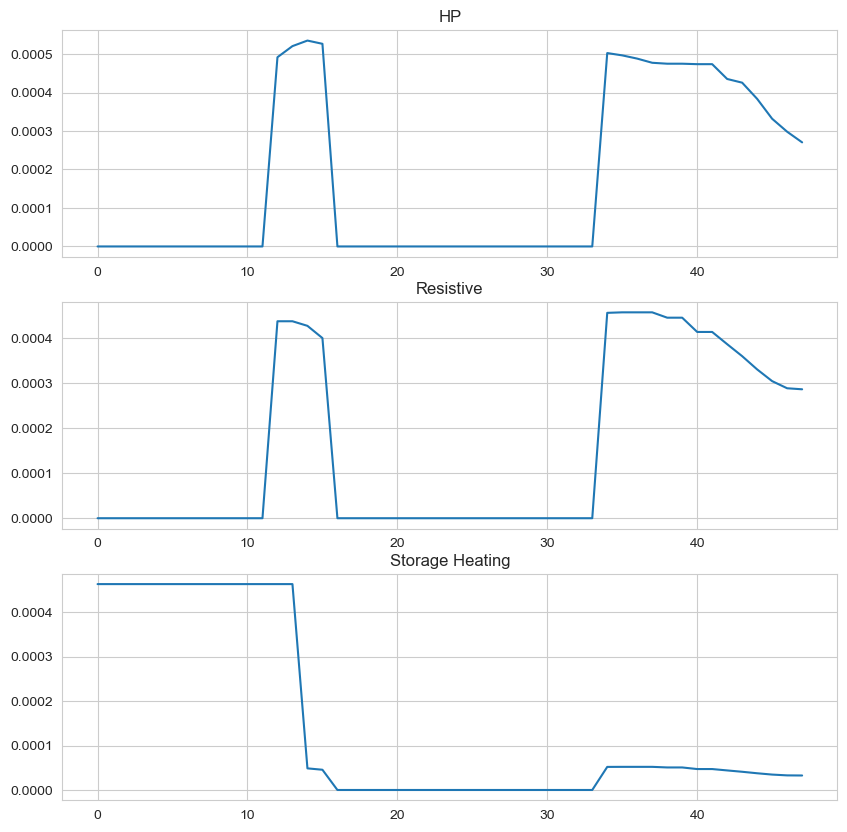

In [116]:
# storage heater, which is derived from resistive heater
normalised_SH_elec = []
for day in range(365):
    normalised_SH_elec_day = np.zeros(48)
    # extract the electricity load for a day
    normalised_Resist_elec_day = normalised_Resist_elec[day*48:(day+1)*48]
    # calculate the energy for day and energy for night, i.e., 0-7
    # This is based on the assumption that 90% are in 0-7.00 am
    tot_energy = normalised_Resist_elec_day.sum()
    if tot_energy:
        day_energy = tot_energy*0.1
        night_energy = tot_energy*0.9

        normalised_SH_elec_day[7*2:] = normalised_Resist_elec_day[7*2:]*day_energy/normalised_Resist_elec_day[7*2:].sum()
        # night demand is uniformly distributed
        normalised_SH_elec_day[:7*2] = night_energy / (7*2)

    normalised_SH_elec.append(normalised_SH_elec_day)

normalised_SH_elec = np.hstack(normalised_SH_elec)
print(normalised_SH_elec.sum()*0.5)
day = 0
plt.figure(figsize = [10,10])
plt.subplot(3,1,1)
plt.plot(normalised_HP_elec[day*48:(day+1)*48])
plt.title("HP")
plt.subplot(3,1,2)
plt.plot(normalised_Resist_elec[day*48:(day+1)*48])
plt.title("Resistive")
plt.subplot(3,1,3)
plt.plot(normalised_SH_elec[day*48:(day+1)*48])
plt.title("Storage Heating")

plt.show()

The demand leverages the shape of UK demand from [here](https://zenodo.org/record/3884859#.ZBy9xHbP0uU)

C:\Users\Zhou_Ming\AppData\Local\Temp\ipykernel_1624\13480640.py:7: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  load_data = pd.pivot_table(load_data, index='date', columns=['time'])


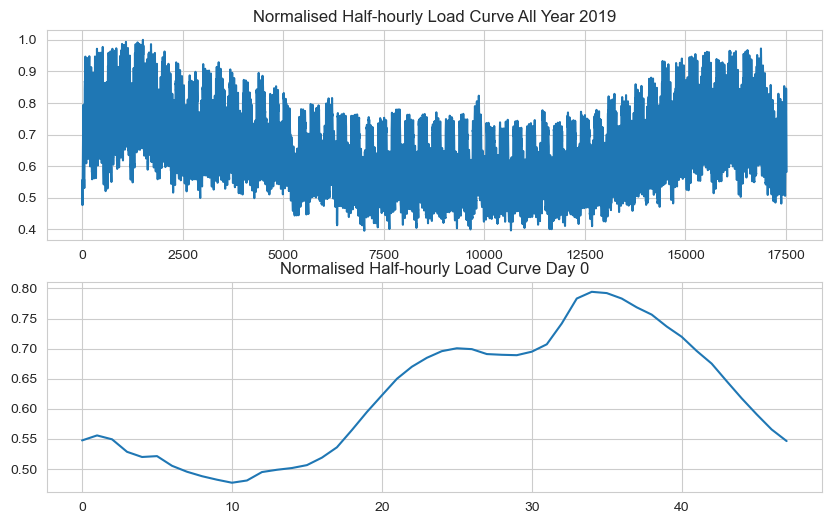

In [117]:
load_data = pd.read_csv(os.path.join(root_path, 'espeni_uk_demand.csv'))

load_data = load_data[['ELEXM_localtime', 'POWER_ESPENI_MW']]
load_data['ELEXM_localtime'] = pd.to_datetime(load_data['ELEXM_localtime'])
load_data['date'] = [d.date() for d in load_data['ELEXM_localtime']]
load_data['time'] = [d.time() for d in load_data['ELEXM_localtime']]
load_data = pd.pivot_table(load_data, index='date', columns=['time'])
load_data.index = pd.to_datetime(load_data.index)

if pd.isna(load_data).any().any():
    load_data = load_data.fillna(method="bfill", axis=1)

## I only want data over 2019 as it's the latest one with full year data
load_data = load_data[load_data.index.year.isin([2019])].values.flatten()
# normalise it
load_data /= load_data.max()

plt.figure(figsize = [10,6])
plt.subplot(2,1,1)
plt.plot(load_data)
plt.title(f"Normalised Half-hourly Load Curve All Year 2019")

plt.subplot(2,1,2)
plt.plot(load_data[day*48:(day+1)*48])
plt.title(f"Normalised Half-hourly Load Curve Day {day}")
plt.show()

### Upgrade Cost Relationship
Data comes from SSEN

In [118]:
def upgrade_cost_estimate(cap_exceed):
    '''
    :param cap_exceed: This is the amount of capacity exceeding the limit (kW)
    :return: the upgrade cost for a primary substation (k£)
    if the input is in MW then the output is in M£
    '''

    cap_list =np.array([3010, 3480, 5170, 8260, 12080, 17240, 22760])
    cost_list = np.array([620, 620, 950, 3500, 3500, 3700, 3700])

    # if cap_exceed > cap_list[-1]:
    #     # print(cap_exceed)
    #     # print('!!!!!!!!!!!! Warning, the exceeding capacity is too large, the estimation may be less accurate')
    #     ## if so, I consider install multiple PSs
    #     no_PS = cap_exceed // cap_list[-1]
    #     cost_base = no_PS * cost_list[-1]
    #
    #     if cap_exceed % cap_list[-1] > 0:
    #         add_cost = upgrade_cost_estimate(cap_exceed % cap_list[-1])
    #         cost_base += add_cost
    #
    #     upgradecost = cost_base
    #
    # elif cap_exceed <= 0:
    #     upgradecost = 0
    # elif cap_exceed <= cap_list[0]:
    #     upgradecost = cost_list[0]
    # else:
    #     upgradecost = cost_list[cap_exceed > cap_list]
    #     upgradecost = np.max(upgradecost)


    if cap_exceed <= 0:
        upgradecost = 0
    else:
        upgradecost = 0.2369*cap_exceed

    return upgradecost

In [146]:
PS_unit_upgrade_cost = np.mean(np.array([620, 620, 950, 3500, 3500, 3700, 3700]) / np.array([3010, 3480, 5170, 8260, 12080, 17240, 22760]))
print(f"The PS upgrade cost is £{PS_unit_upgrade_cost}M/MW")

The PS upgrade cost is £0.23693434159252352M/MW


# Upgrade Cost

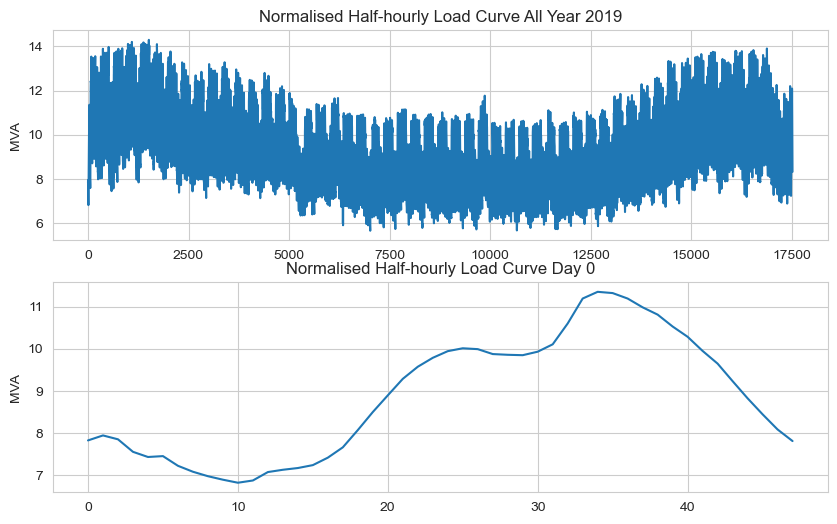

In [120]:
PS_annual_demand_mat_S = UKM_PS_df["Demand (MVA)"].values.reshape(-1,1) * load_data.reshape(1,-1)

# get the active and reactive power
PS_annual_demand_mat_P = PS_annual_demand_mat_S * UKM_PS_df["PF"].values.reshape([-1, 1])
PS_annual_demand_mat_Q = np.sqrt(PS_annual_demand_mat_S**2 - PS_annual_demand_mat_P**2)

i = 0
plt.figure(figsize = [10,6])
plt.subplot(2,1,1)
plt.plot(PS_annual_demand_mat_P[i])
plt.ylabel("MVA")
plt.title(f"Normalised Half-hourly Load Curve All Year 2019")

plt.subplot(2,1,2)
plt.plot(PS_annual_demand_mat_P[i,day*48:(day+1)*48])
plt.title(f"Normalised Half-hourly Load Curve Day {day}")
plt.ylabel("MVA")
plt.show()

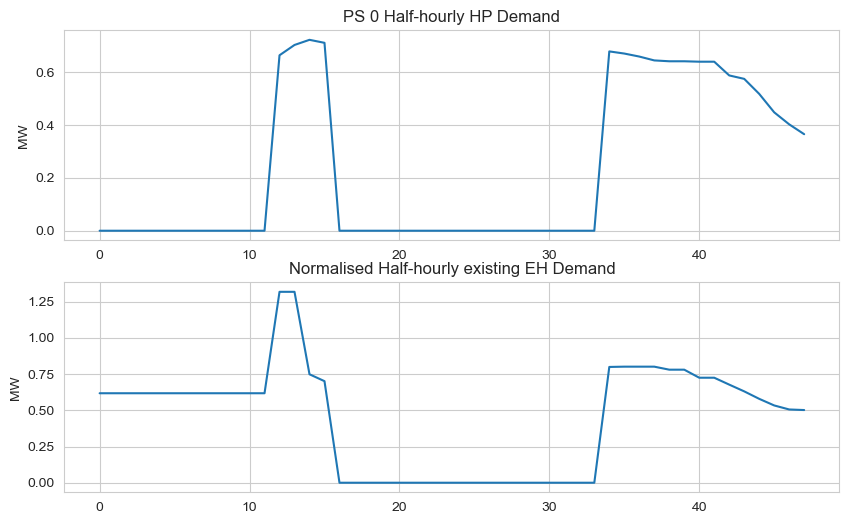

In [121]:
HP_efficiency = 3
SH_efficiency = 1
RH_efficiency = 1

PS_annual_Resistdemand_mat = (UKM_PS_df["Household Meanheatingenergy (MWh)"].values / RH_efficiency * UKM_PS_df["Elec no"].values).reshape(-1,1) * normalised_Resist_elec.reshape(1,-1) / (0.5*normalised_Resist_elec.sum())
PS_annual_HPdemand_mat = (UKM_PS_df["Household Meanheatingenergy (MWh)"].values / HP_efficiency * UKM_PS_df["HP no"].values).reshape(-1,1) * normalised_HP_elec.reshape(1,-1) / (0.5*normalised_HP_elec.sum())
PS_annual_SHdemand_mat = (UKM_PS_df["Household Meanheatingenergy (MWh)"].values / SH_efficiency * UKM_PS_df["Elec no"].values).reshape(-1,1) * normalised_SH_elec.reshape(1,-1) / (0.5*normalised_SH_elec.sum())

# the existing electric heaters' demand is a mixture of the ERH and ESH
PS_annual_EHdemand_mat = (5/11)*PS_annual_SHdemand_mat + (6/11)*PS_annual_Resistdemand_mat

plt.figure(figsize = [10,6])
plt.subplot(2,1,1)
plt.plot(PS_annual_HPdemand_mat[i,day*48:(day+1)*48])
plt.title(f"PS {i} Half-hourly HP Demand")
plt.ylabel("MW")

plt.subplot(2,1,2)
plt.plot(PS_annual_EHdemand_mat[i,day*48:(day+1)*48])
plt.title(f"Normalised Half-hourly existing EH Demand")
plt.ylabel("MW")
plt.show()

In [122]:
PS_annual_newdemand_mat_P = PS_annual_demand_mat_P + PS_annual_HPdemand_mat - PS_annual_EHdemand_mat

print(f"if consider all the time-steps for all PSs, only {np.sum(PS_annual_newdemand_mat_P<0) / PS_annual_newdemand_mat_P.sum() * 100}% steps have negative values")
# remove negative values
PS_annual_newdemand_mat_P = np.maximum(PS_annual_newdemand_mat_P, 0)
PS_newpeak_demand_S = np.max(np.sqrt(PS_annual_newdemand_mat_P**2 + PS_annual_demand_mat_Q**2), axis = 1)
UKM_PS_df['Exceeding Demand by HPs (MVA)'] = PS_newpeak_demand_S - UKM_PS_df["Firm Capacity (MVA)"].values

print(f"{len(UKM_PS_df[UKM_PS_df['Exceeding Demand by HPs (MVA)'] > 0])} out of {len(UKM_PS_df)} PSs in England and Scotland need upgrade")

UKM_PS_df["Upgrade Cost (M£)"] = np.maximum(UKM_PS_df['Exceeding Demand by HPs (MVA)'].values, 0) * PS_unit_upgrade_cost
UKM_PS_df.reset_index(drop=True)

if consider all the time-steps for all PSs, only 0.15519676481605604% steps have negative values
457 out of 3891 PSs in England and Scotland need upgrade


,PS Name,Firm Capacity (MVA),Demand (MVA),PF,RegName,RegCode,"Geo(Long,Lat)",DNO,Zone0,Zone1,Household no,HP no,Elec no,Household Meanheatingenergy (MWh),Exceeding Demand by HPs (MVA),Upgrade Cost (M£)
0,albion st,22.86300,14.312793,0.998712,north west,E12000002,"-2.4950937454916797,53.73015403195597",ENW,E02002623,E02002627,7849.991260,254.871800,184.747538,15.887027,-8.550207,0.000000
1,alderley & chelford,28.42300,16.181206,0.975600,north west,E12000002,"-2.225911796847622,53.30796142675533",ENW,E02003864,E02003858,8874.740516,870.426959,511.296306,15.887027,-12.241794,0.000000
2,alston,1.71206,1.694467,0.985752,north west,E12000002,"-2.4352546655219385,54.81256830516162",ENW,E02005728,E02004008,929.346906,278.145277,28.362187,15.887027,0.706368,0.167363
3,ambleside,17.84830,9.760703,0.993175,north west,E12000002,"-2.963194161426022,54.42314157846089",ENW,E02004015,E02004016,5353.352849,659.712715,315.247362,15.887027,-7.866061,0.000000
4,ancoats north t11 & t12,22.86900,16.170613,0.992857,north west,E12000002,"-2.2271891138444646,53.485968874301655",ENW,E02006902,E02006912,8868.930773,4368.263228,3623.152156,15.887027,-6.698387,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3886,worthington,9.50000,7.220000,0.985506,east midlands,E12000004,"-1.3794,52.7825",WPD,E02005400,E02005401,3544.732870,867.814066,165.936593,15.754403,-0.517489,0.000000
3887,wragby,8.00000,5.620000,0.985506,east midlands,E12000004,"-0.3075,53.2866",WPD,E02005430,E02005494,2759.196500,1186.329187,200.946759,15.754403,0.287613,0.068145
3888,wrangle,12.00000,11.620000,0.985506,east midlands,E12000004,"0.1201,53.0411",WPD,E02005417,E02005436,5704.957887,2589.226642,399.794283,15.754403,5.683350,1.346581
3889,wribbenhall,23.00000,14.720000,0.985506,west midlands,E12000005,"-2.3076,52.3853",WPD,E02006771,E02006777,10512.377958,1954.997231,349.429532,16.555083,-3.912698,0.000000


In [123]:
UKM_PS_df["Upgrade Cost (M£)"].sum()

200.2223869660743

In [124]:
UKM_PS_df[UKM_PS_df["RegName"] == "scottish borders"]["Upgrade Cost (M£)"].sum()

1.296640304375102

In [125]:
UKM_PS_df[UKM_PS_df["RegName"] == "scottish borders"]["HP no"].sum()

16528.769856500166

In [126]:
UKM_PS_df[UKM_PS_df["RegName"] == "orkney islands"][["PS Name", "Firm Capacity (MVA)", "Demand (MVA)", "Exceeding Demand by HPs (MVA)", "Upgrade Cost (M£)", "Household no", "HP no", "Elec no"]]

,PS Name,Firm Capacity (MVA),Demand (MVA),Exceeding Demand by HPs (MVA),Upgrade Cost (M£),Household no,HP no,Elec no
1949,burgar hill,4.069909,1.948238,-0.478690,0.000000,611.034996,608.704729,227.673774
1950,eday,1.153934,0.217494,-0.753798,0.000000,68.213586,65.405376,23.461027
1951,flotta,2.950498,0.152206,-2.725673,0.000000,47.737109,48.227299,26.337070
1955,kirkwall,25.893389,15.930907,-5.702578,0.000000,4996.484079,5050.916586,3239.439773
1956,lyness,1.362112,0.739288,0.000629,0.000149,231.866219,230.981965,86.394163
1958,north hoy,0.279564,0.118721,-0.060724,0.000000,37.234945,37.092944,13.873871
1960,rousay,2.801945,0.304412,-2.313767,0.000000,95.474218,93.656892,44.844148
1961,sanday,1.106062,0.779271,0.327604,0.077621,244.406281,234.344587,84.059829
1962,shapinsay,1.277668,0.515680,-0.450685,0.000000,161.735114,158.656529,75.966826
1963,st mary's,4.831064,2.841181,-0.500336,0.000000,891.092702,879.327214,455.200039


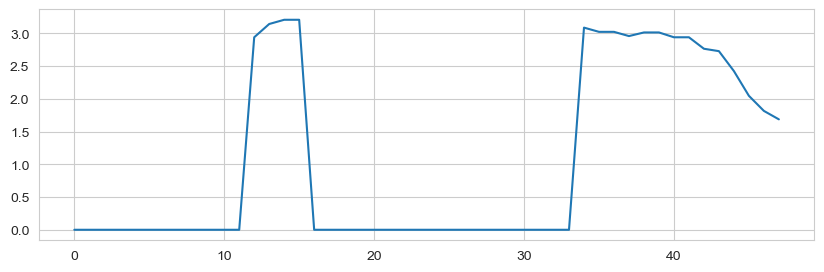

In [127]:
plt.figure(figsize = [10,3])
day = 3
plt.plot(1*23000*normalised_HP_elec[day*48:(day+1)*48] / HP_efficiency / (0.5*normalised_HP_elec.sum()))

In [128]:
peak = np.max(23613.471203792094*normalised_HP_elec / HP_efficiency / (0.5*normalised_HP_elec.sum()))
print(f"The Scotland peak demand for a single HP is ~{peak}kW, based on Scotland mean annual heating energy")

peak = np.max(15578.882071970696*normalised_HP_elec / HP_efficiency / (0.5*normalised_HP_elec.sum()))
print(f"The England peak demand for a single HP is ~{peak}kW, based on England mean annual heating energy")

The Scotland peak demand for a single HP is ~5.270301882754795kW, based on Scotland mean annual heating energy
The England peak demand for a single HP is ~3.4770581083367684kW, based on England mean annual heating energy


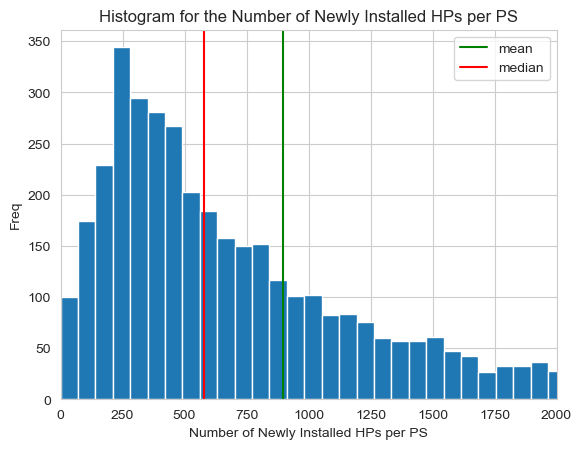

In [129]:
UKM_PS_df["HP no"].hist(bins = 300)
plt.axvline(UKM_PS_df["HP no"].mean(), color = 'g', label = "mean")
plt.axvline(UKM_PS_df["HP no"].median(), color = 'r', label = "median")
plt.xlim([0, 2000])
plt.title("Histogram for the Number of Newly Installed HPs per PS")
plt.xlabel("Number of Newly Installed HPs per PS")
plt.ylabel("Freq")
plt.legend()

# Scaling up the cost 
We only modelled the primary upgrade cost. We need to, based on Ofgem's data, scale the cost up to the whole distribution network cost

In [130]:
# load the ofgem data
ofgem_path = os.path.join(os.path.dirname(os.getcwd()), "FuelPoverty_data")
DNO_cost_break_down = pd.read_excel(os.path.join(ofgem_path, "DNO_upgrade_cost_breakdown.xlsx"))
DNO_cost_break_down

,DNO,cost_name,£M
0,ENW,Connections,23.054755
1,ENW,Primary,19.596542
2,ENW,Secondary,150.000000
3,ENW,Fault,32.276657
4,ENW,NTCC,0.000000
5,NPG,Connections,150.000000
6,NPG,Primary,65.706052
7,NPG,Secondary,357.348703
8,NPG,Fault,58.789625
9,NPG,NTCC,4.610951


In [131]:
# based on DNO_cost_break_down, for each DNO, extract the Primary cost and the total cost
DNO_primary_cost = DNO_cost_break_down[DNO_cost_break_down["cost_name"] == "Primary"].reset_index()[['DNO', '£M']].copy()
DNO_primary_cost

,DNO,£M
0,ENW,19.596542
1,NPG,65.706052
2,WPD,260.518732
3,UKPN,171.757925
4,SPEN,108.357349
5,SSEN,156.772334


In [132]:
# total cost is the summation
DNO_total_cost = DNO_cost_break_down.groupby("DNO").sum(numeric_only = True).reset_index()[['DNO', '£M']].copy()
# sort by the DNO order in DNO_primary_cost
DNO_total_cost = DNO_total_cost.set_index("DNO").loc[DNO_primary_cost["DNO"]].reset_index()
DNO_total_cost

,DNO,£M
0,ENW,224.927954
1,NPG,636.455331
2,WPD,946.397695
3,UKPN,538.328530
4,SPEN,438.040346
5,SSEN,494.956772


In [133]:
# now calculate the scaling factor = pri cost / tot cost
DNO_scaling_factor = DNO_total_cost.copy()
DNO_scaling_factor["scale"] = DNO_total_cost["£M"] / DNO_primary_cost["£M"]
DNO_scaling_factor = DNO_scaling_factor[['DNO', 'scale']].copy()
# convert DNO_scaling_factor to a dictionary
DNO_scaling_factor_dict = {DNO_scaling_factor.iloc[i]["DNO"]: DNO_scaling_factor.iloc[i]["scale"] for i in range(len(DNO_scaling_factor))}
DNO_scaling_factor_dict

{'ENW': 11.477941176470596,
 'NPG': 9.686403508771935,
 'WPD': 3.632743362831859,
 'UKPN': 3.134228187919463,
 'SPEN': 4.042553191489362,
 'SSEN': 3.1571691176470584}

In [134]:
# now scale up the cost
UKM_PS_df["Upgrade Cost (M£)"] = UKM_PS_df["Upgrade Cost (M£)"] * UKM_PS_df["DNO"].map(DNO_scaling_factor_dict)
UKM_PS_df

,PS Name,Firm Capacity (MVA),Demand (MVA),PF,RegName,RegCode,"Geo(Long,Lat)",DNO,Zone0,Zone1,Household no,HP no,Elec no,Household Meanheatingenergy (MWh),Exceeding Demand by HPs (MVA),Upgrade Cost (M£)
0,albion st,22.86300,14.312793,0.998712,north west,E12000002,"-2.4950937454916797,53.73015403195597",ENW,E02002623,E02002627,7849.991260,254.871800,184.747538,15.887027,-8.550207,0.000000
1,alderley & chelford,28.42300,16.181206,0.975600,north west,E12000002,"-2.225911796847622,53.30796142675533",ENW,E02003864,E02003858,8874.740516,870.426959,511.296306,15.887027,-12.241794,0.000000
2,alston,1.71206,1.694467,0.985752,north west,E12000002,"-2.4352546655219385,54.81256830516162",ENW,E02005728,E02004008,929.346906,278.145277,28.362187,15.887027,0.706368,1.920980
3,ambleside,17.84830,9.760703,0.993175,north west,E12000002,"-2.963194161426022,54.42314157846089",ENW,E02004015,E02004016,5353.352849,659.712715,315.247362,15.887027,-7.866061,0.000000
4,ancoats north t11 & t12,22.86900,16.170613,0.992857,north west,E12000002,"-2.2271891138444646,53.485968874301655",ENW,E02006902,E02006912,8868.930773,4368.263228,3623.152156,15.887027,-6.698387,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4202,worthington,9.50000,7.220000,0.985506,east midlands,E12000004,"-1.3794,52.7825",WPD,E02005400,E02005401,3544.732870,867.814066,165.936593,15.754403,-0.517489,0.000000
4203,wragby,8.00000,5.620000,0.985506,east midlands,E12000004,"-0.3075,53.2866",WPD,E02005430,E02005494,2759.196500,1186.329187,200.946759,15.754403,0.287613,0.247555
4204,wrangle,12.00000,11.620000,0.985506,east midlands,E12000004,"0.1201,53.0411",WPD,E02005417,E02005436,5704.957887,2589.226642,399.794283,15.754403,5.683350,4.891783
4205,wribbenhall,23.00000,14.720000,0.985506,west midlands,E12000005,"-2.3076,52.3853",WPD,E02006771,E02006777,10512.377958,1954.997231,349.429532,16.555083,-3.912698,0.000000


# Finally, get the estimated cost for each region and store the data

In [135]:
upgrade_cost_df = UKM_PS_df[["RegCode", "RegName", "Upgrade Cost (M£)", "Household no", "HP no", "Elec no", "Firm Capacity (MVA)", "Demand (MVA)"]].copy()
upgrade_cost_df["Number of PS"] = 1
upgrade_cost_df = upgrade_cost_df.groupby("RegCode").agg({'RegName': 'first', 'Upgrade Cost (M£)': 'sum', "Number of PS":'sum', "Household no":"sum", "HP no":'sum', 'Elec no':'sum', "Firm Capacity (MVA)":'sum', "Demand (MVA)":'sum'}).reset_index()

upgrade_cost_df

,RegCode,RegName,Upgrade Cost (M£),Number of PS,Household no,HP no,Elec no,Firm Capacity (MVA),Demand (MVA)
0,E12000001,north east,0.000000,131,1175680.0,75754.102652,39388.187853,3481.040000,1939.486881
1,E12000002,north west,42.279838,534,3153404.0,264239.935232,182503.006567,10389.270846,5749.562841
2,E12000003,yorkshire and the humber,32.411081,391,2330658.0,229690.652108,112995.108007,8272.518800,4729.332990
3,E12000004,east midlands,54.327027,306,2037332.0,268510.886965,134719.572472,6228.462750,4149.688448
4,E12000005,west midlands,49.446957,201,2429493.0,217314.106743,126442.066569,5798.257000,3401.907456
5,E12000006,east of england,299.523280,377,2628782.0,468666.345818,213870.658241,4620.341331,4200.901236
6,E12000007,london,1.587447,225,3423890.0,488969.193207,303442.319494,8989.101005,5389.807791
7,E12000008,south east,44.201923,511,3807966.0,481868.242623,323981.308612,11435.273561,6929.689176
8,E12000009,south west,82.901616,469,2448881.0,522275.792592,282211.418741,7766.864962,4773.143826
9,S12000005,clackmannanshire,0.000000,4,22734.0,1298.784338,818.271434,78.500000,39.928778


In [136]:
## create a column for the averaged network upgrade cost assigned to each household
upgrade_cost_df["Upgrade Cost per Household (£)"] = upgrade_cost_df["Upgrade Cost (M£)"] / upgrade_cost_df["Household no"] * 10**6
upgrade_cost_df

,RegCode,RegName,Upgrade Cost (M£),Number of PS,Household no,HP no,Elec no,Firm Capacity (MVA),Demand (MVA),Upgrade Cost per Household (£)
0,E12000001,north east,0.000000,131,1175680.0,75754.102652,39388.187853,3481.040000,1939.486881,0.000000
1,E12000002,north west,42.279838,534,3153404.0,264239.935232,182503.006567,10389.270846,5749.562841,13.407682
2,E12000003,yorkshire and the humber,32.411081,391,2330658.0,229690.652108,112995.108007,8272.518800,4729.332990,13.906408
3,E12000004,east midlands,54.327027,306,2037332.0,268510.886965,134719.572472,6228.462750,4149.688448,26.665770
4,E12000005,west midlands,49.446957,201,2429493.0,217314.106743,126442.066569,5798.257000,3401.907456,20.352788
5,E12000006,east of england,299.523280,377,2628782.0,468666.345818,213870.658241,4620.341331,4200.901236,113.939946
6,E12000007,london,1.587447,225,3423890.0,488969.193207,303442.319494,8989.101005,5389.807791,0.463638
7,E12000008,south east,44.201923,511,3807966.0,481868.242623,323981.308612,11435.273561,6929.689176,11.607752
8,E12000009,south west,82.901616,469,2448881.0,522275.792592,282211.418741,7766.864962,4773.143826,33.852856
9,S12000005,clackmannanshire,0.000000,4,22734.0,1298.784338,818.271434,78.500000,39.928778,0.000000


In [137]:
upgrade_cost_df["Upgrade Cost per Household (£)"].max()

739.3756403224768

In [138]:
## save
upgrade_cost_df.to_csv(os.path.join(network_root_path, "reg_upgrade_cost.csv"), index=False)

In [139]:
## upgrade cost for England and Scotland
upgrade_cost_df_up = upgrade_cost_df.copy()
upgrade_cost_df_up["Nation"] = None
upgrade_cost_df_up.loc[upgrade_cost_df_up["RegCode"].str.contains("E"), "Nation"] = "England"
upgrade_cost_df_up.loc[upgrade_cost_df_up["RegCode"].str.contains("S"), "Nation"] = "Scotland"

upgrade_cost_df_up = upgrade_cost_df_up.groupby("Nation").sum(numeric_only = True)
upgrade_cost_df_up

,Upgrade Cost (M£),Number of PS,Household no,HP no,Elec no,Firm Capacity (MVA),Demand (MVA),Upgrade Cost per Household (£)
Nation,,,,,,,,
England,606.67917,3145,23436086.0,3.017289e+06,1.719554e+06,66981.130255,41263.520646,234.196841
Scotland,108.71765,746,2372777.0,4.701713e+05,2.536883e+05,11037.123286,5017.594643,2239.873908


In [140]:
Reg_heating_prop_df = upgrade_cost_df.copy()
Reg_heating_prop_df["Off-gas-prop %"] = Reg_heating_prop_df["HP no"] / Reg_heating_prop_df["Household no"] * 100
Reg_heating_prop_df["elec-prop %"] = Reg_heating_prop_df["Elec no"] / Reg_heating_prop_df["Household no"] * 100

Reg_heating_prop_df.drop(columns=["HP no", "Elec no", "Household no", "Number of PS"], inplace=True)
Reg_heating_prop_df

,RegCode,RegName,Upgrade Cost (M£),Firm Capacity (MVA),Demand (MVA),Upgrade Cost per Household (£),Off-gas-prop %,elec-prop %
0,E12000001,north east,0.000000,3481.040000,1939.486881,0.000000,6.443429,3.350247
1,E12000002,north west,42.279838,10389.270846,5749.562841,13.407682,8.379514,5.787492
2,E12000003,yorkshire and the humber,32.411081,8272.518800,4729.332990,13.906408,9.855185,4.848206
3,E12000004,east midlands,54.327027,6228.462750,4149.688448,26.665770,13.179535,6.612549
4,E12000005,west midlands,49.446957,5798.257000,3401.907456,20.352788,8.944834,5.204463
5,E12000006,east of england,299.523280,4620.341331,4200.901236,113.939946,17.828270,8.135732
6,E12000007,london,1.587447,8989.101005,5389.807791,0.463638,14.281101,8.862502
7,E12000008,south east,44.201923,11435.273561,6929.689176,11.607752,12.654216,8.507988
8,E12000009,south west,82.901616,7766.864962,4773.143826,33.852856,21.327120,11.524097
9,S12000005,clackmannanshire,0.000000,78.500000,39.928778,0.000000,5.712960,3.599329


In [141]:
np.save(os.path.join(os.getcwd(), "data_for_plot", "All_elec_res_dict.npy"), Reg_heating_prop_df[["RegCode", "elec-prop %"]].set_index("RegCode").to_dict()['elec-prop %'], allow_pickle=True)

In [142]:
Reg_heating_prop_df.sort_values(by = 'elec-prop %')

,RegCode,RegName,Upgrade Cost (M£),Firm Capacity (MVA),Demand (MVA),Upgrade Cost per Household (£),Off-gas-prop %,elec-prop %
11,S12000008,east ayrshire,0.000000,247.000000,95.319861,0.000000,6.178989,1.919837
18,S12000019,midlothian,0.000000,141.000000,71.004607,0.000000,9.405203,2.992568
33,S12000040,west lothian,0.000000,340.000000,159.442193,0.000000,5.555016,3.130842
0,E12000001,north east,0.000000,3481.040000,1939.486881,0.000000,6.443429,3.350247
9,S12000005,clackmannanshire,0.000000,78.500000,39.928778,0.000000,5.712960,3.599329
36,S12000045,east dunbartonshire,0.000000,156.000000,77.365903,0.000000,5.233993,4.030838
2,E12000003,yorkshire and the humber,32.411081,8272.518800,4729.332990,13.906408,9.855185,4.848206
4,E12000005,west midlands,49.446957,5798.257000,3401.907456,20.352788,8.944834,5.204463
32,S12000039,west dunbartonshire,0.000000,143.874476,66.422988,0.000000,8.778223,5.351833
31,S12000038,renfrewshire,0.000000,326.500000,144.651277,0.000000,5.976664,5.537683
